In [1]:
import os
import logging
import collections
import datetime

import gpflow
import tensorflow as tf
import numpy as np
import pandas as pd

import sklearn as sk
import sklearn.preprocessing

import IPython.display as ipd
import matplotlib.pyplot as plt

import GP.kernels as kernels
from GP.models import GPLVM
from GP.expectations import analyticExpectation, gaussHermiteExpectation, unscentedExpectation, montecarloExpectation

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

opt = gpflow.train.ScipyOptimizer()

# tf.logging.set_verbosity(tf.logging.FATAL)
gpflow.logdensities.logger.setLevel(logging.CRITICAL)
np.random.seed(42)
tf.random.set_random_seed(42)

In [2]:
def negative_log_predictive_density(observed_value, predict):
    predict_mean, predict_var = predict.loc[:,'mean'], predict.loc[:,'variance']
    return np.log(2*np.pi)/2 + np.sum(np.log(predict_var) + ((observed_value-predict_mean)**2)/predict_var)/len(observed_value)

def lag_dataframe(d,i):
    if i == 0:
        return d
    else:
        return d.shift(i).rename(lambda c: f'{c}_lag{i}', axis='columns')

def add_lag(lag,*data):
    return pd.concat([
        lag_dataframe(x,i) for x in data for i in range(0,lag+1)
    ], axis=1)

def kernel_name(k):
    if type(k) is gpflow.kernels.Sum:
        return '+'.join([kernel_name(k) for k in k.kernels])
    if type(k) is gpflow.kernels.Product:
        return '*'.join([kernel_name(k) for k in k.kernels])
    if type(k).__name__ == 'MLP':
        return f'MLP{k.layers}'
    else:
        return type(k).__name__

def init_kernel_hypers(k):
    if type(k) is gpflow.kernels.Sum:
        for subk in k.kernels:
            init_kernel_hypers(subk)
    elif isinstance(k, gpflow.kernels.Stationary):
        k.lengthscales = 10*np.sqrt(np.var(X_train, axis=0))
        k.variance = np.var(y_train)
    elif isinstance(k, gpflow.kernels.Static):
        pass
    elif type(k) is gpflow.kernels.Linear:
        k.variance = (1/X_train.shape[1])*1e-2*np.var(y_train)*np.ones(1+lag)
    elif type(k) is gpflow.kernels.Periodic:
        k.variance = np.var(y_train)
    elif type(k).__name__ == 'MLP':
        k.rbf.variance = np.var(y_train)
    else:
        raise Exception(f"Can't handle {type(k)}")
        
def plot(ax, t, mean=None, var=None, label=None, color='C0', linestyle='-'):
    if type(t) is pd.Series:
        label = t.name
        t, mean = t.index, t.values
    elif type(t) is pd.DataFrame:
        t, mean, var = t.index, t.loc[:,'mean'], t.loc[:,'variance']
    ax.plot(t, mean, lw=2, color=color, label=label, linestyle=linestyle)
    if (var is not None):
        ax.fill_between(t, mean - 2*np.sqrt(var), mean + 2*np.sqrt(var), color=color, alpha=0.4, label=f'{label} (95% CI)')

def free_simulate(m, propagate_uncertain=True):   
    variances = pd.DataFrame(index=X.index, columns=X.columns, dtype=np.float)
    means = pd.DataFrame(y_scaler.transform(X.values).copy() ,index=X.index, columns=X.columns, dtype=np.float)
    
    variances.iloc[:lag+1,:] = m.X_var.value[:lag+1,:]
    means.iloc[lag+1:] = np.nan
    
    y_name = y.columns[0]
    for i in range(lag,len(X)-1):
        y_new = np.nan
        tries = 0
        while np.isnan(y_new) and tries < 10:
            if propagate_uncertain:
                y_new, y_var = m.predict_y_uncertain(means.iloc[[i]],variances.iloc[[i]])
            else:
                y_new, y_var = m.predict_y(means.iloc[[i]])
            tries+= 1

        if np.isnan(y_new):
            print("NAN")
            break

        for j in range(0,lag+1):
            if (i+1+j < len(X)):
                cname = f'{y_name}_lag{j}' if j > 0 else y_name
                means[cname].iloc[i+1+j] = y_new
                variances[cname].iloc[i+1+j] = y_var[0][0]

                means.iloc[i+1+j,j+1:] = means.iloc[i,:lag-j].values
                variances.iloc[i+1+j,j+1:] = variances.iloc[i,:lag-j].values
    return means, variances

In [3]:
save_or_load = 'save'
dataset = 'passengers'

In [4]:
dataset_path_friendly = dataset.replace(' ','_')
if save_or_load not in ['save','load','rerun','loadsave']:
    raise Exception(f'Invalid operation {save_or_load}')
if dataset == 'passengers':
    y = pd.read_csv('data/international-airline-passengers.csv')
    y['Month'] = pd.to_datetime(y['Month'])
    y = y.sort_values('Month').set_index('Month')
    y['passengers in thousands'] = y['passengers in thousands'].astype(float)
    t = y.index
else:
    raise Exception(f'Unknown Dataset {dataset}')

In [5]:
lag = 11
train_size = int(12*4)

X = add_lag(lag,y)
X_train = X.iloc[lag:lag+train_size].values
X_train_var = 1e-6*np.ones(X_train.shape)
y_train = y.iloc[lag+1:lag+train_size+1].values

y_scaler = sk.preprocessing.StandardScaler()
y_train = y_scaler.fit_transform(y_train)
X_train = y_scaler.transform(X_train)

inducing_points = X_train

In [6]:
kernels = [
    gpflow.kernels.RBF(X.shape[1], ARD=True) + gpflow.kernels.Linear(X.shape[1], ARD=True),
    gpflow.kernels.Matern12(X.shape[1], ARD=True) + gpflow.kernels.Linear(X.shape[1], ARD=True),
    gpflow.kernels.Periodic(X.shape[1]) + gpflow.kernels.RBF(X.shape[1], ARD=True) + gpflow.kernels.Linear(X.shape[1], ARD=True),
]
expectations_and_runs = [
    (analyticExpectation, 1),
    (unscentedExpectation, 1),
    (gaussHermiteExpectation(2, X.shape[1]), 1),
    (montecarloExpectation(2**X.shape[1]), 10),
    (montecarloExpectation(2*X.shape[1]), 10)]

if save_or_load in ['save','rerun']:
    train_mode = 'GP'

    def make_model_params(k, expectation=None, predict_mode='GP'):
        return {
            'expectation': expectation, 'train_mode': 'GP', 'predict_mode': predict_mode,
            'X_mean': X_train.copy(), 'X_var': X_train_var.copy(), 'Y': y_train,
            'kern': k, 'Z': inducing_points.copy(), 'M': inducing_points.shape[0]
        }
    models = collections.OrderedDict((kernel_name(k), GPLVM(**make_model_params(k))) for k in kernels)

    for m in models.values():
        m.likelihood.variance = 0.01 * np.var(y_train)
#         m.likelihood.variance.trainable = False
        m.X_mean.trainable = False
        m.X_var.trainable = False
        m.feature.trainable = False
        init_kernel_hypers(m.kern)

In [7]:
if save_or_load in ['save','rerun']:
    # tf.logging.set_verbosity(tf.logging.ERROR)
    for m in models.values():
        ipd.display(ipd.HTML(f'<h4>{kernel_name(m.kern)}</h4>'))
        print('Start',datetime.datetime.now().strftime("%I:%M %p"))
        %time opt.minimize(m, maxiter=5000)
    # tf.logging.set_verbosity(tf.logging.INFO)

    for m in models.values():
        m.X_var.value[:,:] = m.likelihood.variance.value
    print('Actual finish', datetime.datetime.now().strftime("%I:%M %p"))

    gplvms = [
        GPLVM(**make_model_params(k,e,predict_mode='GPLVM'))
        for e,r in expectations_and_runs for i in range(r) for k in kernels
        if not (e.__name__ == 'analytic' and kernel_name(k) != 'SquaredExponential+Linear')
    ]

    for gplvm in gplvms:
        gplvm.assign(models[kernel_name(gplvm.kern)].read_trainables())

In [8]:
models_index = pd.MultiIndex.from_tuples(
    [('NARX', 'analytic', kernel_name(k), 0) for k in kernels] +
    [
        ('GPLVM', e.__name__, kernel_name(k), i)
        for e,r in expectations_and_runs for i in range(r) for k in kernels
        if not (e.__name__ == 'analytic' and kernel_name(k) != 'SquaredExponential+Linear')
    ],
    names=['mode','expectation', 'kernel','run']
)

result_columns = pd.MultiIndex.from_tuples(
    [(*x, r) for x in models_index for r in ['mean', 'variance']],
    names=models_index.names + [None]
)

In [9]:
if save_or_load in ['save','rerun']:
    narx_results = np.array([frame.values[:,0] for m in models.values() for frame in free_simulate(m, propagate_uncertain=False)])
    gplvm_results = np.array([frame.values[:,0] for m in gplvms for frame in free_simulate(m, propagate_uncertain=True)])

    results = pd.DataFrame(
        np.concatenate([narx_results, gplvm_results]).T,
        index=y.index,
        columns=result_columns
    ).sort_index(axis=1)

    # Un-normalize results
    results.loc[:, pd.IndexSlice[:,:,:,:,'mean']] = y_scaler.inverse_transform(results.loc[:, pd.IndexSlice[:,:,:,:,'mean']])
    results.loc[:, pd.IndexSlice[:,:,:,:,'variance']] = y_scaler.var_ * results.loc[:, pd.IndexSlice[:,:,:,:,'variance']]

    if save_or_load == 'save':
        os.makedirs("./points", exist_ok=True)
        results.to_hdf(f'./points/{dataset_path_friendly}.hdf', key='points')
elif save_or_load in ['load', 'loadsave']:
    results = pd.read_hdf(f'./points/{dataset_path_friendly}.hdf', key='points')

In [10]:
metrics = pd.DataFrame({
    'RMSE': [
        np.sqrt(sk.metrics.mean_squared_error(y.iloc[lag+train_size+1:], results.iloc[lag+train_size+1:][(*k, 'mean')]))
        if results.iloc[lag+train_size+1:][(*k, 'mean')].isnull().any() != True
        else np.nan
        for k in models_index
    ],
    'NLPD': [
        negative_log_predictive_density(y.iloc[lag+train_size+1:,0], results.iloc[lag+train_size+1:][k])
        if results.iloc[lag+train_size+1:][(*k, 'mean')].isnull().any() != True
        else np.nan
        for k in models_index
    ]
    ,
    'length': [
        len(results[(*k, 'mean')].dropna())
        for k in models_index
    ]
}, index=models_index).sort_index(axis=1)

if save_or_load in ['save', 'loadsave']:
    os.makedirs(f"./tabs/", exist_ok=True)
    metrics.unstack('run')['NLPD'].T.describe().loc[['mean','std']].T.to_csv(f"./tabs/acc_{dataset_path_friendly}_nlpd_mean.csv")
    metrics.unstack('run')['RMSE'].T.describe().loc[['mean','std']].T.to_csv(f"./tabs/acc_{dataset_path_friendly}_rmse_mean.csv")
    metrics.unstack('run')['length'].T.describe().loc[['mean','std']].T.to_csv(f"./tabs/acc_{dataset_path_friendly}_length_mean.csv")
    metrics.to_csv(f"./tabs/acc_{dataset_path_friendly}.csv")

GPLVM_montecarlo(4096)_Periodic+SquaredExponential+Linear_1 ('NLPD', 9.404903696074278) ('RMSE', 45.53379236056184) ('length', 144.0)


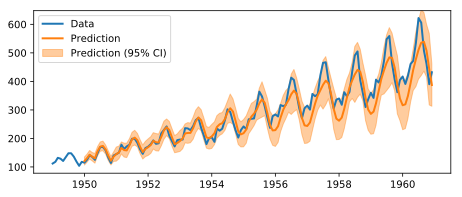

GPLVM_montecarlo(4096)_Periodic+SquaredExponential+Linear_6 ('NLPD', 9.429687169015924) ('RMSE', 45.34506948232947) ('length', 144.0)


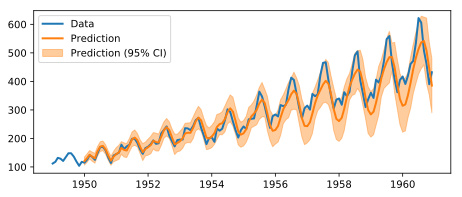

GPLVM_montecarlo(4096)_Periodic+SquaredExponential+Linear_8 ('NLPD', 9.436781334990183) ('RMSE', 45.945838029260166) ('length', 144.0)


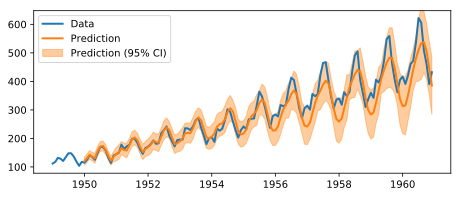

GPLVM_montecarlo(4096)_Periodic+SquaredExponential+Linear_5 ('NLPD', 9.438081502546657) ('RMSE', 45.722407925638954) ('length', 144.0)


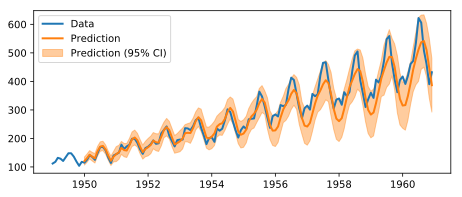

GPLVM_montecarlo(4096)_Periodic+SquaredExponential+Linear_3 ('NLPD', 9.451751158573304) ('RMSE', 45.44937182815395) ('length', 144.0)


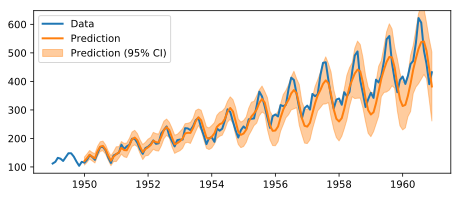

GPLVM_montecarlo(4096)_Periodic+SquaredExponential+Linear_0 ('NLPD', 9.502553360673252) ('RMSE', 45.1903216573169) ('length', 144.0)


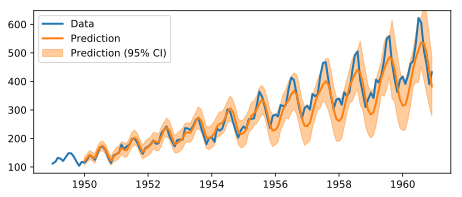

GPLVM_montecarlo(4096)_Periodic+SquaredExponential+Linear_7 ('NLPD', 9.50754115628563) ('RMSE', 45.57277021256861) ('length', 144.0)


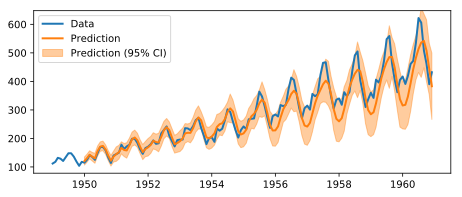

GPLVM_montecarlo(4096)_Periodic+SquaredExponential+Linear_9 ('NLPD', 9.628307851886806) ('RMSE', 45.93919552943032) ('length', 144.0)


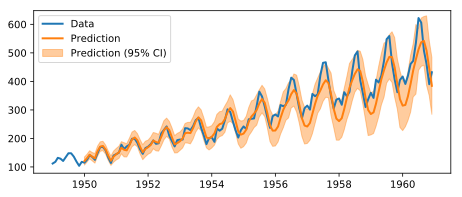

GPLVM_montecarlo(4096)_Periodic+SquaredExponential+Linear_4 ('NLPD', 9.762095219926602) ('RMSE', 45.202545349108135) ('length', 144.0)


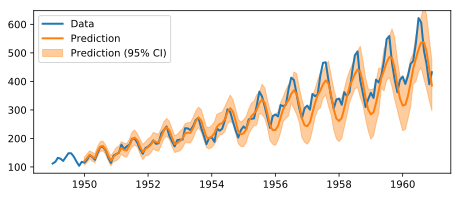

GPLVM_montecarlo(4096)_Periodic+SquaredExponential+Linear_2 ('NLPD', 9.93517913537113) ('RMSE', 45.347661597645214) ('length', 144.0)


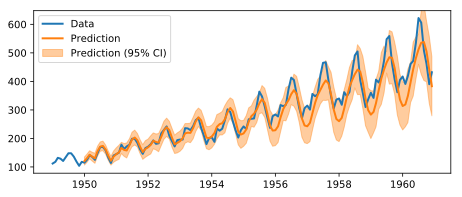

GPLVM_montecarlo(4096)_Matern12+Linear_1 ('NLPD', 11.031558648209586) ('RMSE', 67.10828793931879) ('length', 144.0)


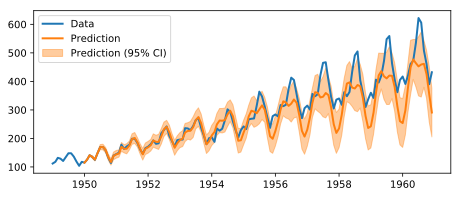

GPLVM_montecarlo(4096)_Matern12+Linear_4 ('NLPD', 11.088018781139237) ('RMSE', 66.8070799050875) ('length', 144.0)


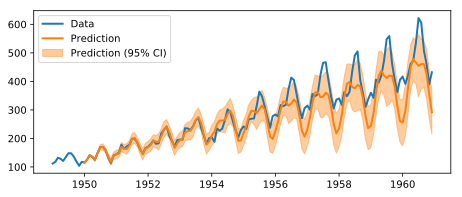

GPLVM_montecarlo(4096)_Matern12+Linear_7 ('NLPD', 11.168330579241205) ('RMSE', 66.92109200288944) ('length', 144.0)


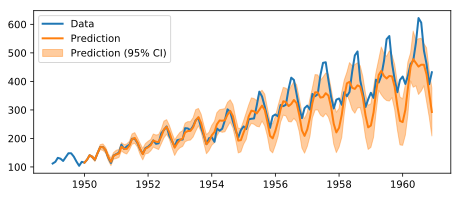

GPLVM_montecarlo(4096)_Matern12+Linear_9 ('NLPD', 11.177421149024104) ('RMSE', 66.72900465126413) ('length', 144.0)


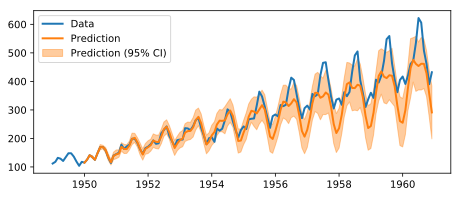

GPLVM_montecarlo(4096)_Matern12+Linear_5 ('NLPD', 11.177790853884582) ('RMSE', 67.14371954740615) ('length', 144.0)


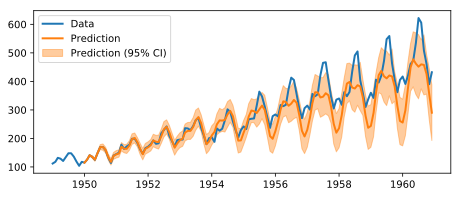

GPLVM_montecarlo(4096)_Matern12+Linear_2 ('NLPD', 11.285238642608528) ('RMSE', 67.06577014346256) ('length', 144.0)


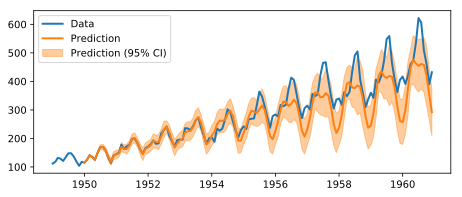

GPLVM_montecarlo(4096)_Matern12+Linear_3 ('NLPD', 11.39096434209909) ('RMSE', 66.68137248162762) ('length', 144.0)


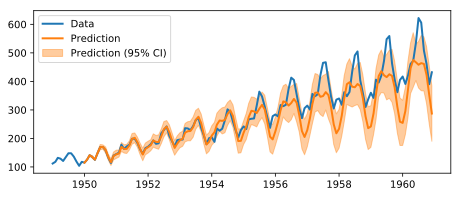

GPLVM_montecarlo(4096)_Matern12+Linear_0 ('NLPD', 11.422876076024425) ('RMSE', 67.06072725442986) ('length', 144.0)


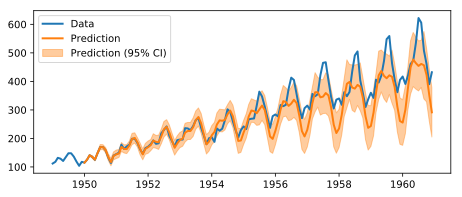

GPLVM_montecarlo(4096)_Matern12+Linear_6 ('NLPD', 11.699238424166884) ('RMSE', 66.71405156210633) ('length', 144.0)


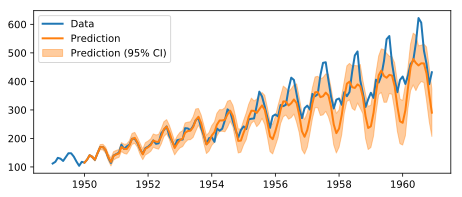

GPLVM_montecarlo(4096)_Matern12+Linear_8 ('NLPD', 11.737169164461696) ('RMSE', 66.58414957048554) ('length', 144.0)


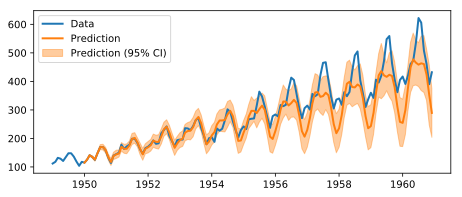

GPLVM_montecarlo(4096)_SquaredExponential+Linear_1 ('NLPD', 13.054721480483597) ('RMSE', 68.74758353098423) ('length', 144.0)


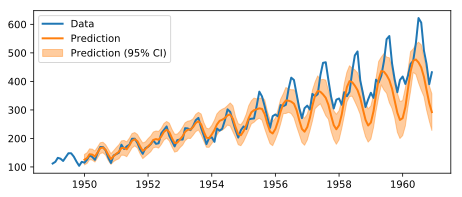

GPLVM_montecarlo(4096)_SquaredExponential+Linear_2 ('NLPD', 13.059911502337357) ('RMSE', 69.36775885695386) ('length', 144.0)


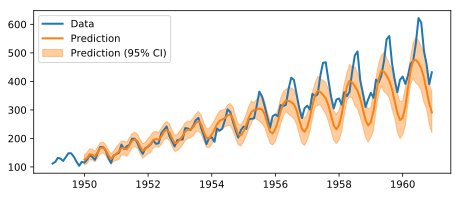

GPLVM_montecarlo(4096)_SquaredExponential+Linear_0 ('NLPD', 13.19966572164156) ('RMSE', 68.59156156666505) ('length', 144.0)


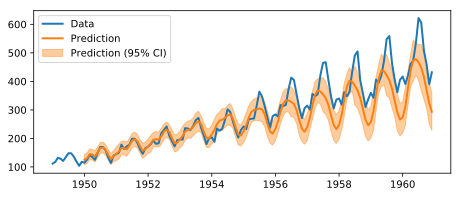

GPLVM_montecarlo(4096)_SquaredExponential+Linear_3 ('NLPD', 13.321889078749303) ('RMSE', 68.90694401586566) ('length', 144.0)


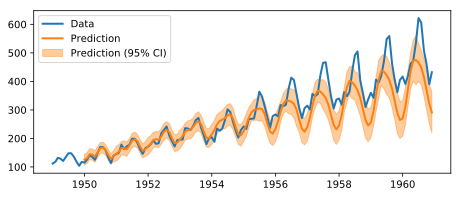

GPLVM_montecarlo(4096)_SquaredExponential+Linear_5 ('NLPD', 13.322407139247058) ('RMSE', 68.97633328302037) ('length', 144.0)


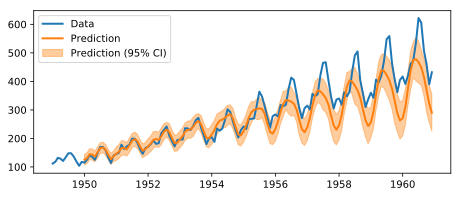

GPLVM_montecarlo(4096)_SquaredExponential+Linear_7 ('NLPD', 13.394206829335142) ('RMSE', 68.56562547500624) ('length', 144.0)


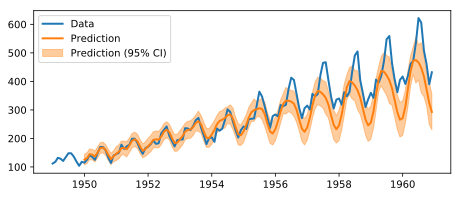

GPLVM_montecarlo(4096)_SquaredExponential+Linear_4 ('NLPD', 13.446081677637574) ('RMSE', 68.88550523662262) ('length', 144.0)


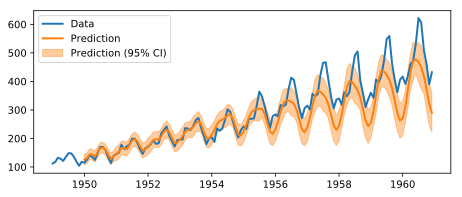

GPLVM_montecarlo(4096)_SquaredExponential+Linear_6 ('NLPD', 13.582769104951256) ('RMSE', 68.71649052894142) ('length', 144.0)


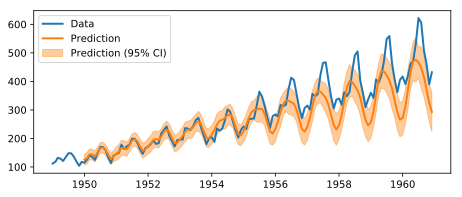

GPLVM_montecarlo(4096)_SquaredExponential+Linear_9 ('NLPD', 13.68219982412097) ('RMSE', 68.40364333916287) ('length', 144.0)


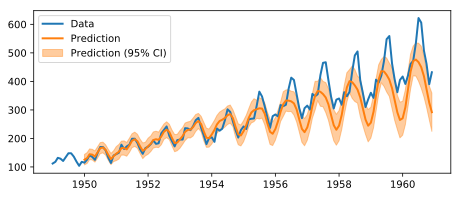

GPLVM_montecarlo(4096)_SquaredExponential+Linear_8 ('NLPD', 13.777860270588713) ('RMSE', 68.53346343848337) ('length', 144.0)


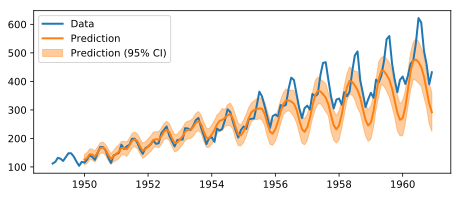

NARX_analytic_Periodic+SquaredExponential+Linear_0 ('NLPD', 14.002742108891999) ('RMSE', 44.99246290963632) ('length', 144.0)


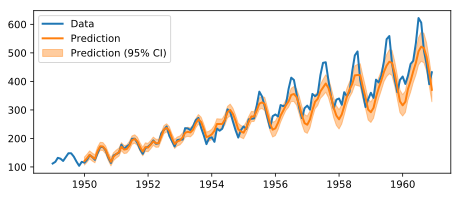

NARX_analytic_Matern12+Linear_0 ('NLPD', 20.694236095275834) ('RMSE', 70.75115986761298) ('length', 144.0)


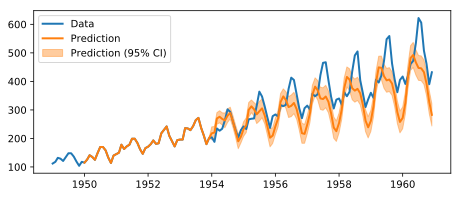

NARX_analytic_SquaredExponential+Linear_0 ('NLPD', 21.82254269138259) ('RMSE', 69.39570417684433) ('length', 144.0)


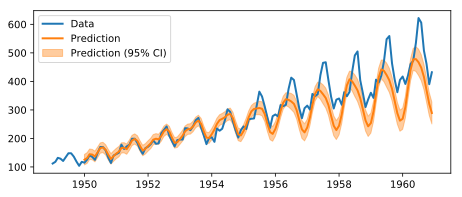

GPLVM_montecarlo(24)_SquaredExponential+Linear_3 ('NLPD', nan) ('RMSE', nan) ('length', 47.0)


C:\Users\sentr\Documents\Home\Programas\WinPython2\python-3.6.7.amd64\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in sqrt


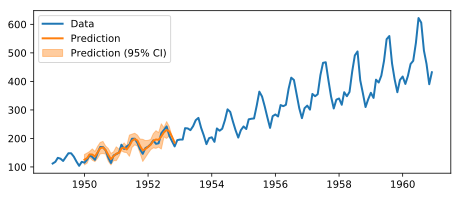

GPLVM_montecarlo(24)_SquaredExponential+Linear_7 ('NLPD', nan) ('RMSE', nan) ('length', 38.0)


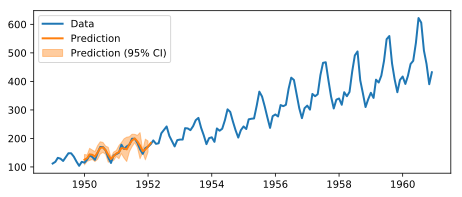

GPLVM_montecarlo(24)_SquaredExponential+Linear_5 ('NLPD', nan) ('RMSE', nan) ('length', 36.0)


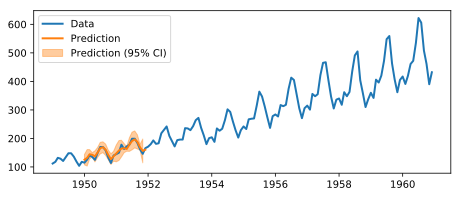

GPLVM_montecarlo(24)_SquaredExponential+Linear_8 ('NLPD', nan) ('RMSE', nan) ('length', 33.0)


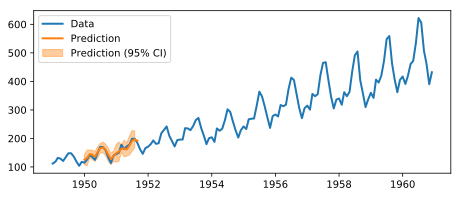

GPLVM_montecarlo(24)_Periodic+SquaredExponential+Linear_8 ('NLPD', nan) ('RMSE', nan) ('length', 25.0)


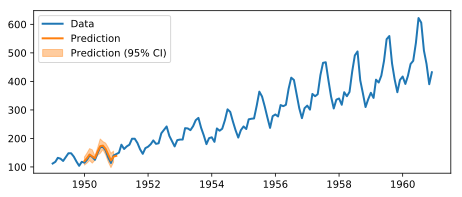

GPLVM_montecarlo(24)_SquaredExponential+Linear_6 ('NLPD', nan) ('RMSE', nan) ('length', 25.0)


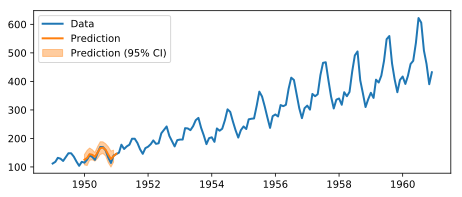

GPLVM_montecarlo(24)_Periodic+SquaredExponential+Linear_9 ('NLPD', nan) ('RMSE', nan) ('length', 24.0)


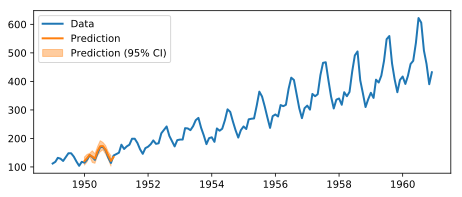

GPLVM_montecarlo(24)_SquaredExponential+Linear_2 ('NLPD', nan) ('RMSE', nan) ('length', 24.0)


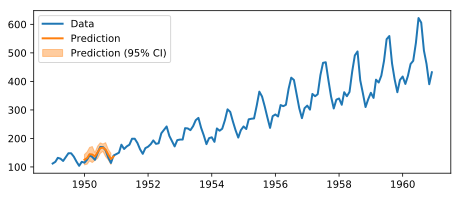

GPLVM_montecarlo(24)_SquaredExponential+Linear_1 ('NLPD', nan) ('RMSE', nan) ('length', 24.0)


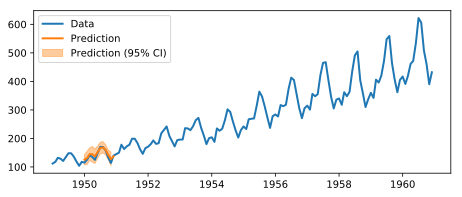

GPLVM_montecarlo(24)_SquaredExponential+Linear_9 ('NLPD', nan) ('RMSE', nan) ('length', 23.0)


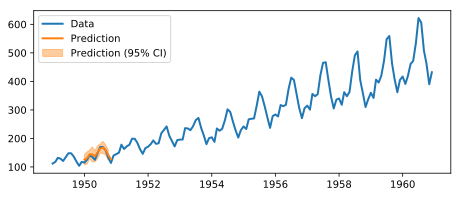

GPLVM_montecarlo(24)_SquaredExponential+Linear_4 ('NLPD', nan) ('RMSE', nan) ('length', 23.0)


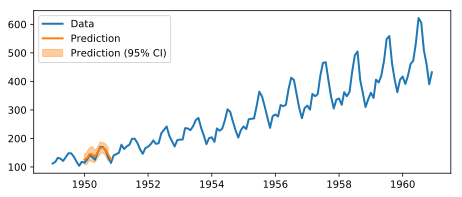

GPLVM_montecarlo(24)_Periodic+SquaredExponential+Linear_6 ('NLPD', nan) ('RMSE', nan) ('length', 22.0)


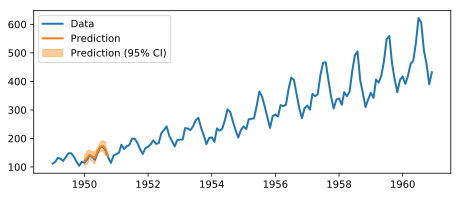

GPLVM_montecarlo(24)_Periodic+SquaredExponential+Linear_4 ('NLPD', nan) ('RMSE', nan) ('length', 18.0)


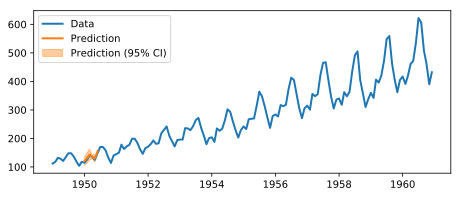

GPLVM_montecarlo(24)_Matern12+Linear_1 ('NLPD', nan) ('RMSE', nan) ('length', 18.0)


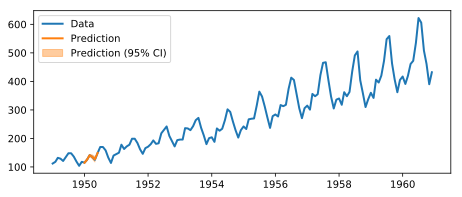

GPLVM_montecarlo(24)_Periodic+SquaredExponential+Linear_0 ('NLPD', nan) ('RMSE', nan) ('length', 17.0)


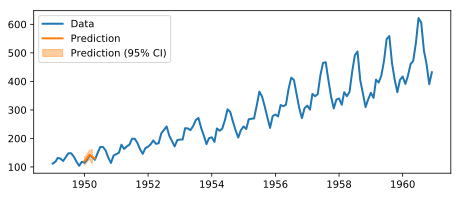

GPLVM_montecarlo(24)_Periodic+SquaredExponential+Linear_5 ('NLPD', nan) ('RMSE', nan) ('length', 17.0)


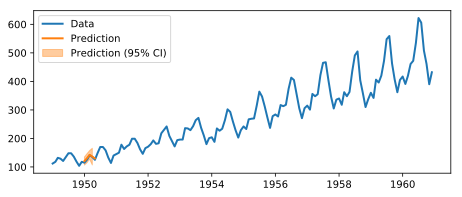

GPLVM_montecarlo(24)_Periodic+SquaredExponential+Linear_2 ('NLPD', nan) ('RMSE', nan) ('length', 17.0)


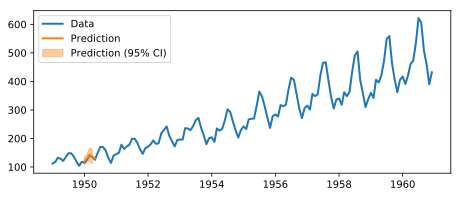

GPLVM_montecarlo(24)_Periodic+SquaredExponential+Linear_7 ('NLPD', nan) ('RMSE', nan) ('length', 17.0)


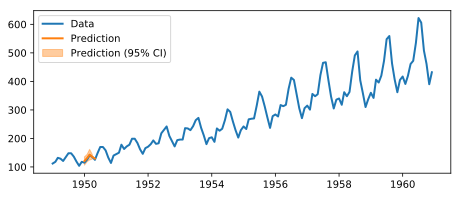

GPLVM_montecarlo(24)_Periodic+SquaredExponential+Linear_1 ('NLPD', nan) ('RMSE', nan) ('length', 16.0)


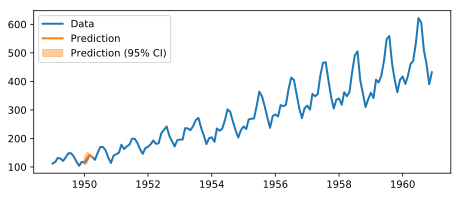

GPLVM_montecarlo(24)_SquaredExponential+Linear_0 ('NLPD', nan) ('RMSE', nan) ('length', 16.0)


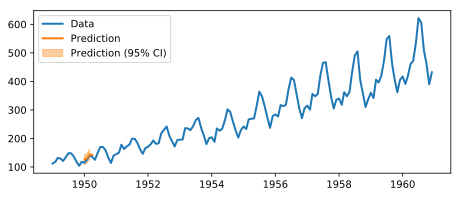

GPLVM_montecarlo(24)_Matern12+Linear_0 ('NLPD', nan) ('RMSE', nan) ('length', 15.0)


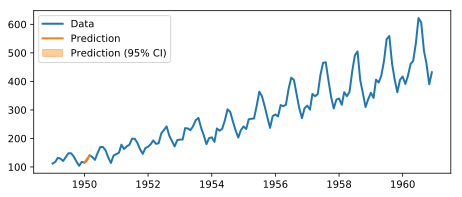

GPLVM_montecarlo(24)_Matern12+Linear_6 ('NLPD', nan) ('RMSE', nan) ('length', 15.0)


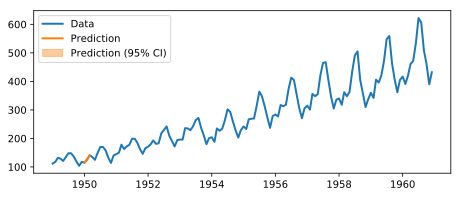

GPLVM_montecarlo(24)_Periodic+SquaredExponential+Linear_3 ('NLPD', nan) ('RMSE', nan) ('length', 15.0)


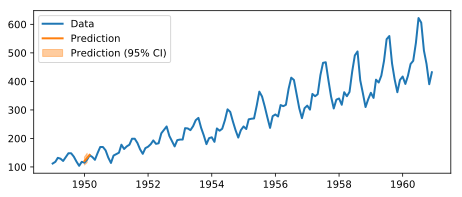

GPLVM_montecarlo(24)_Matern12+Linear_3 ('NLPD', nan) ('RMSE', nan) ('length', 14.0)


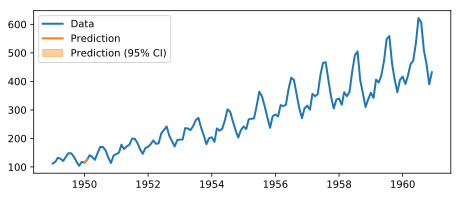

GPLVM_montecarlo(24)_Matern12+Linear_5 ('NLPD', nan) ('RMSE', nan) ('length', 14.0)


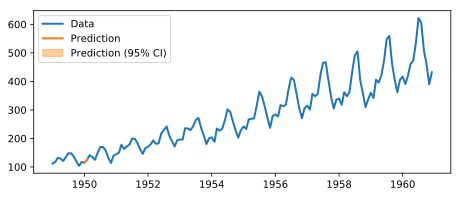

GPLVM_montecarlo(24)_Matern12+Linear_9 ('NLPD', nan) ('RMSE', nan) ('length', 14.0)


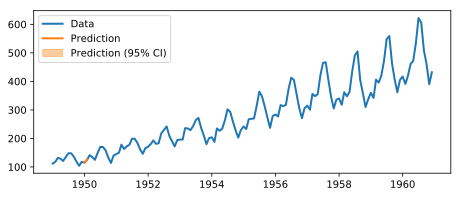

GPLVM_montecarlo(24)_Matern12+Linear_7 ('NLPD', nan) ('RMSE', nan) ('length', 13.0)


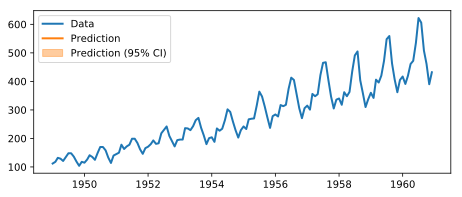

GPLVM_montecarlo(24)_Matern12+Linear_8 ('NLPD', nan) ('RMSE', nan) ('length', 13.0)


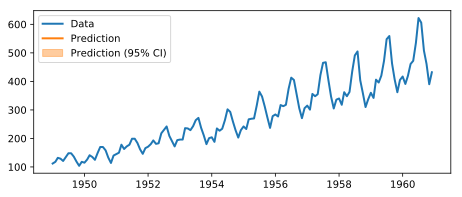

GPLVM_montecarlo(24)_Matern12+Linear_4 ('NLPD', nan) ('RMSE', nan) ('length', 13.0)


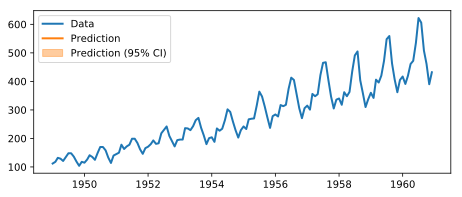

GPLVM_montecarlo(24)_Matern12+Linear_2 ('NLPD', nan) ('RMSE', nan) ('length', 13.0)


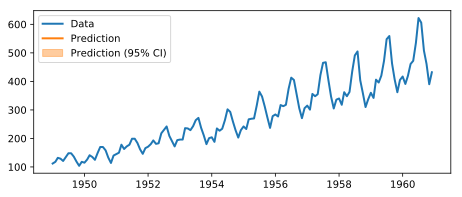

In [11]:
if save_or_load in ['save', 'loadsave']:
    os.makedirs(f"figs/{dataset}/", exist_ok=True)
for (mode,e,k,run), kMetrics in metrics.sort_values(by='length',ascending=False).sort_values(by='NLPD', kind='mergesort').iterrows():
    figname = f'{mode}_{e}_{k}_{run}'
    print(figname, *kMetrics.items())
    f, ax = plt.subplots(1,1, figsize=np.array([5,2])*1.5)
    plot(ax,t,y.values, label='Data', linestyle='-')
    a = ax.get_ylim()
    plot(ax,results.iloc[lag+1:][mode,e,k,run], color='C1', label='Prediction')
    ax.set_ylim(a)
    ax.legend()
    if save_or_load in ['save', 'loadsave']:
        plt.savefig(f'figs/{dataset}/{figname}.pdf', bbox_inches='tight')
    plt.show()